In [72]:
import numpy as np 
import pickle 
import matplotlib.pyplot as plt 
from typing import List, Dict
import sys 
sys.path.insert(0, "../../")
from loaders import get_dataset
PATH = "../recursive-clustering-experiment/MAE_SMALL_STED_neural-activity-states_recursive_clusters_tree.pkl"
NODE_IDS = [101010101, 101010102]
class_to_analyze = None

In [73]:
_, _, test_loader = get_dataset(
    name="neural-activity-states",
    transform=None,
    training=True,
    path=None,
    batch_size=64,
    n_channels=1,
    
)
dataset = test_loader.dataset
label_dict = {0: "Block", 1: "0MgGlyBic", 2: "GluGly", 3: "48hTTX"}

Processing dataset..: 100%|██████████| 6021/6021 [00:04<00:00, 1282.27it/s]


['0MgGlyBic' '48hTTX' 'Block' 'GluGly'] [1423 2541 1545  512]


Processing dataset..: 100%|██████████| 1176/1176 [00:00<00:00, 1473.17it/s]


['0MgGlyBic' '48hTTX' 'Block' 'GluGly'] [420 413 230 113]


Processing dataset..: 100%|██████████| 1510/1510 [00:01<00:00, 1446.55it/s]

['0MgGlyBic' '48hTTX' 'Block' 'GluGly'] [299 519 492 200]

=== NAS dataset ===
(array([0, 1, 2, 3]), array([512, 512, 512, 512]))
(array([0, 1, 2, 3]), array([113, 113, 113, 113]))
(array([0, 1, 2, 3]), array([200, 200, 200, 200]))
Training size: 2048
Validation size: 452
Test size: 800




In [74]:
class Node:
    def __init__(self, cluster_id, depth, data=None):
        self.cluster_id = cluster_id
        self.depth = depth
        self.data = data
        self.parent = None
        self.children = []
    
    def add_child(self, child_node):
        child_node.parent = self
        self.children.append(child_node)
    
    def __str__(self):
        return f"Node(cluster_id={self.cluster_id}, depth={self.depth}, children={len(self.children)})"
    
    def __repr__(self):
        return self.__str__()


    

In [75]:
def print_tree(node, indent=0):
    """Helper function to visualize the tree structure"""
    print("  " * indent + str(node))
    if node.data is not None:
        print("  " * (indent + 1) + f"Data: {node.data}")
    for child in node.children:
        print_tree(child, indent + 1)

def build_tree_from_nested_lists(nested_lists, depth=0, parent_id=0):
    """
    Recursively builds a tree from nested lists.
    
    Args:
        nested_lists: A list that may contain nested lists or data elements
        depth: Current depth in the tree
        parent_id: Cluster ID of the parent node
    
    Returns:
        The root node of the tree
    """
    # Create a root node for the current level
    current_id = parent_id
    root = Node(cluster_id=current_id, depth=depth)
    
    # Process each item in the nested list
    for i, item in enumerate(nested_lists):
        # Assign a unique cluster ID for the current node
        current_id = parent_id * 100 + i + 1
        
        if isinstance(item, list):
            # Recursive case: item is a nested list (cluster)
            child_node = build_tree_from_nested_lists(item, depth + 1, current_id)
            root.add_child(child_node)
            # print(f"child_node: {child_node.parent}")
        else:
            # Base case: item is data
            leaf_node = Node(cluster_id=current_id, depth=depth + 1, data=item)
            root.add_child(leaf_node)
            # print(f"leaf_node: {leaf_node.parent}")
    
    return root

In [76]:
with open(PATH, "rb") as f:
    tree = pickle.load(f)

root = build_tree_from_nested_lists(tree)


In [77]:
def get_depth_nodes(root, depth):
    for child in root.children:
        if child.depth == depth:
            yield child
        else:
            yield from get_depth_nodes(child, depth)

In [78]:
def get_specific_node(root, node_id, node=None):
    for child in root.children:
        # print(child.cluster_id, child.cluster_id == 10101)
        if child.cluster_id == node_id:
            print(f"Found node {node_id}")
            node = child
        else:
            found_node = get_specific_node(root=child, node_id=node_id, node=node)
            if found_node is not None:
                return found_node
    return node


In [79]:
nodes_to_compare = []
for node_id in NODE_IDS:
    node = get_specific_node(root, node_id)
    nodes_to_compare.append(node)


Found node 101010101
Found node 101010102


In [80]:
def find_leaf_nodes(node, leaves=None):
    if leaves is None:
        leaves = []
    
    if not node.children:  # This is a leaf node
        leaves.append(node)
    else:
        for child in node.children:
            find_leaf_nodes(child, leaves)
            
    return leaves

all_nodes = find_leaf_nodes(root)
total_nodes = 0
for n in all_nodes:
    total_nodes += n.data["data"].shape[0]

print(total_nodes)



800


In [81]:
def extract_mean_feature_vector(node):
    leaf_nodes = find_leaf_nodes(node)
    all_data = np.concatenate([leaf.data["data"] for leaf in leaf_nodes])
    return np.mean(all_data, axis=0)

101010101: (array(['0MgGlyBic', 'Block', 'GluGly'], dtype='<U9'), array([26,  2,  4]))
101010102: (array(['0MgGlyBic', 'GluGly'], dtype='<U9'), array([ 5, 15]))


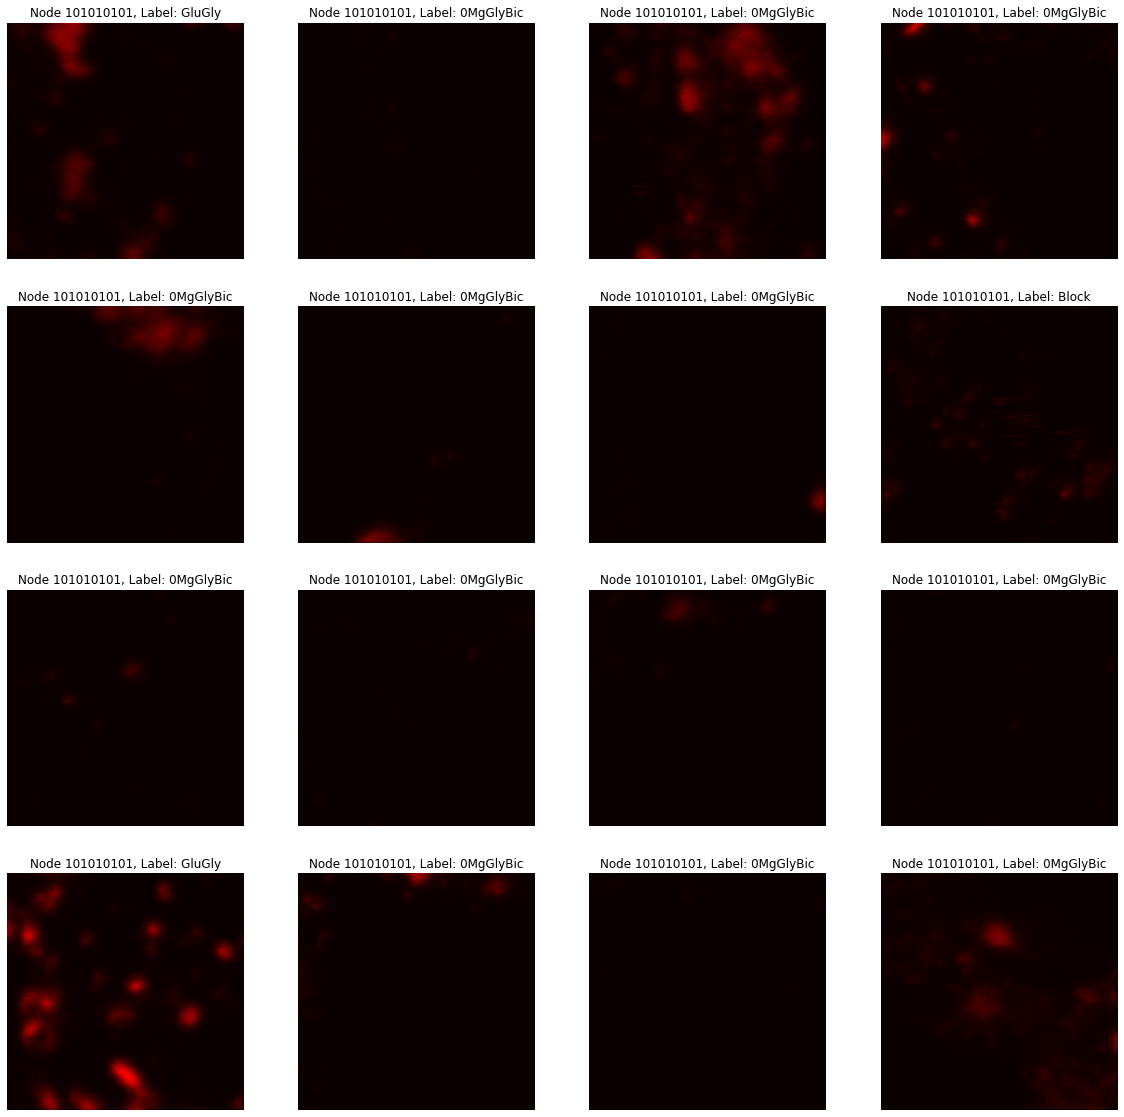

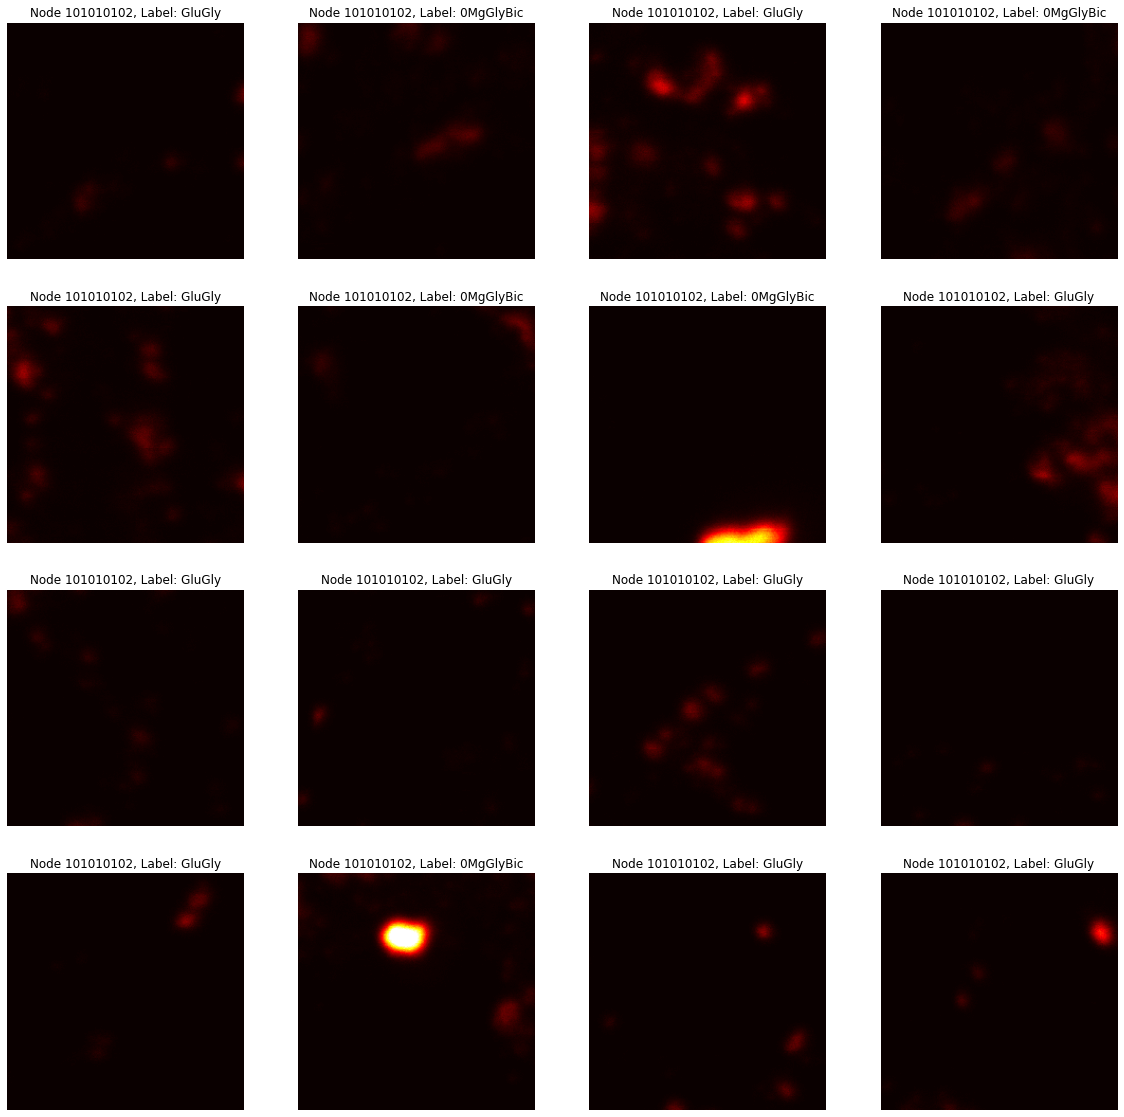

In [82]:
def plot_examples(node_list):
    all_imgs = {node.cluster_id: [] for node in node_list}
    all_masks = {node.cluster_id: [] for node in node_list}
    all_labels = {node.cluster_id: [] for node in node_list}
    counts = {node.cluster_id: [] for node in node_list}
    for node in node_list:
        node_id = node.cluster_id
        leaf_nodes = find_leaf_nodes(node)
        for leaf in leaf_nodes:
            data_idx = [item["dataset-idx"].item() for item in leaf.data["metadata"]]
            imgs = [dataset[idx][0].squeeze().numpy() for idx in data_idx]
            masks = [dataset[idx][1]["mask"] for idx in data_idx]
            labels = [dataset[idx][1]["label"] for idx in data_idx]
            conditions = [label_dict[item] for item in labels]
            counts[node_id].extend(conditions)
            all_masks[node_id].extend(masks)
            all_imgs[node_id].extend(imgs)
            all_labels[node_id].extend(labels)

    for key in counts.keys():
        print(f"{key}: {np.unique(counts[key], return_counts=True)}")
    for key in all_imgs.keys():
        imgs = all_imgs[key]
        labels = all_labels[key]
        assert len(imgs) == len(labels)
        fig, axs = plt.subplots(4, 4, figsize=(20, 20))
        N = len(imgs)  

        indices = np.random.choice(N, size=min(N, 16), replace=False)
        for i, idx in enumerate(indices):
            img = imgs[idx]
            label = labels[idx]
            ax = axs.ravel()[i]
            ax.imshow(img, cmap="hot", vmin=0, vmax=1)
            ax.set_title(f"Node {key}, Label: {label_dict[label]}")
            ax.axis("off")
        plt.show()

    return all_imgs, all_labels, all_masks
imgs, labels, masks =plot_examples(nodes_to_compare)


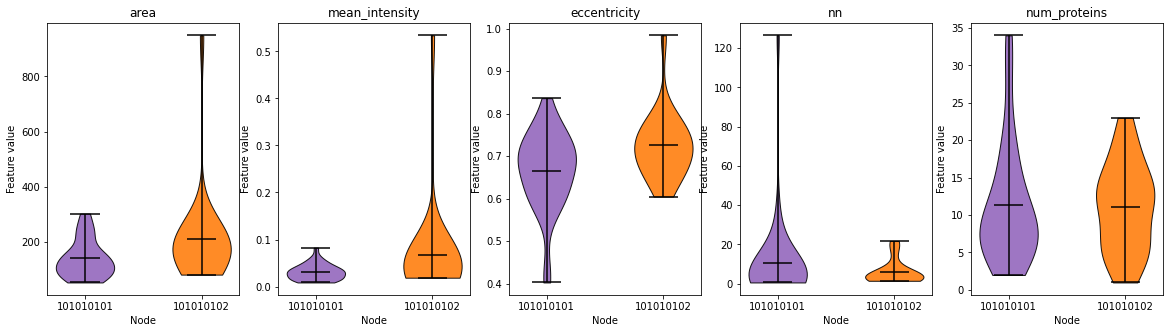

In [91]:
from skimage import measure
from scipy.spatial import distance
def cumulative_features(imgs: dict, labels: dict, masks: dict):
    feature_dict = {
        key: {
           
        } for key in imgs.keys()
    }
    for key in imgs.keys():
        area, mean_intensity, eccentricity, nn, num_proteins = [], [], [], [], []
        key_imgs, key_labels, key_masks = imgs[key], labels[key], masks[key]
        for image, lab, mask in zip(key_imgs, key_labels, key_masks):
            if class_to_analyze is not None and label_dict[lab] != class_to_analyze:
                continue 
            label_image, numprots = measure.label(mask, return_num=True)
            num_proteins.append(numprots)
            rprops = measure.regionprops(label_image, intensity_image=image)
            img_area, img_intensity, img_eccentricity, img_nn = [], [], [], []
            centroids = [p.weighted_centroid for p in rprops]
            for prop in rprops:
                distances = distance.cdist(centroids, [prop.weighted_centroid], metric="euclidean")
                distances = distances[1:]
                if distances.shape[0] > 0:
                    img_nn.append(np.min(distances))
                img_area.append(prop.area)
                img_intensity.append(prop.mean_intensity)
                img_eccentricity.append(prop.eccentricity)
            area.append(np.mean(img_area))
            mean_intensity.append(np.mean(img_intensity))
            eccentricity.append(np.mean(img_eccentricity))
            nn.append(np.mean(img_nn))
        
        nn = [value for value in nn if not np.isnan(value)]
        feature_dict[key]["area"] = area
        feature_dict[key]["mean_intensity"] = mean_intensity
        feature_dict[key]["eccentricity"] = eccentricity
        feature_dict[key]["nn"] = nn
        feature_dict[key]["num_proteins"] = num_proteins


    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    for i, feature in enumerate(list(feature_dict.values())[0].keys()):
        f1, f2 = [feature_dict[key][feature] for key in feature_dict.keys()]
        v1 = axs[i].violinplot(positions=[0], dataset=f1, showmeans=True)
        v2 = axs[i].violinplot(positions=[1], dataset=f2, showmeans=True)
        v1["bodies"][0].set_facecolor("tab:purple")
        v2["bodies"][0].set_facecolor("tab:orange")
        v1["bodies"][0].set_edgecolor("black")
        v2["bodies"][0].set_edgecolor("black")
        v2["bodies"][0].set_alpha(0.9)
        v1["bodies"][0].set_alpha(0.9)
        v1["cmeans"].set_color("black")
        v2["cmeans"].set_color("black")
        v1["cmaxes"].set_color("black")
        v2["cmaxes"].set_color("black")
        v1["cmins"].set_color("black")
        v2["cmins"].set_color("black")
        v1["cbars"].set_color("black")
        v2["cbars"].set_color("black")
        axs[i].set_title(feature)
        axs[i].set_ylabel("Feature value")
        axs[i].set_xlabel("Node")
        axs[i].set_xticks([0, 1])
        axs[i].set_xticklabels(list(feature_dict.keys()))
            
    plt.show()


        
cumulative_features(imgs, labels, masks=masks)


In [56]:
from matplotlib import colormaps
def plot_frequencies(node_list):
    num_clusters = len(node_list)
    states = ["Block", "48hTTX", "0MgGlyBic", "GluGly"]
    cluster_counts = {condition: {node.cluster_id: 0 for node in node_list} for condition in states}
    condition_counts = {node.cluster_id: {condition: 0 for condition in states} for node in node_list}

    for _, node in enumerate(node_list):
        node_id = node.cluster_id
        leaf_nodes = find_leaf_nodes(node)
        for leaf in leaf_nodes:
            all_metadata = leaf.data["metadata"]
            labels = [item["condition"] for item in all_metadata]
            uniques, counts = np.unique(labels, return_counts=True)
            for u, c in zip(uniques, counts):
                cluster_counts[u][node_id] += c
                condition_counts[node_id][u] += c


    r = np.arange(1, num_clusters+1)
    ogr = np.arange(1, num_clusters+1)
    width = 0.2
    H = 10 if num_clusters < 10 else 20
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    colors = {"Block": "tab:blue", "48hTTX": "tab:red", "0MgGlyBic": "tab:green", "GluGly": "tab:brown"}
    for idx, condition in enumerate(states):
        height = [cluster_counts[condition][i] for i in condition_counts.keys()]
        ax.bar(r, height, width=width, label=condition, align="edge", color=colors[condition])
        r = [x + width for x in r]
    ax.set(
        title="Cluster counts",
        xticks=[item + (width * 4/2) for item in ogr],
        xticklabels=[node.cluster_id for node in node_list],
    )
    ax.tick_params(axis='both', labelsize=10 + num_clusters)  # Set fontsize of the tick labels
    ax.legend()
    plt.show()
    return condition_counts



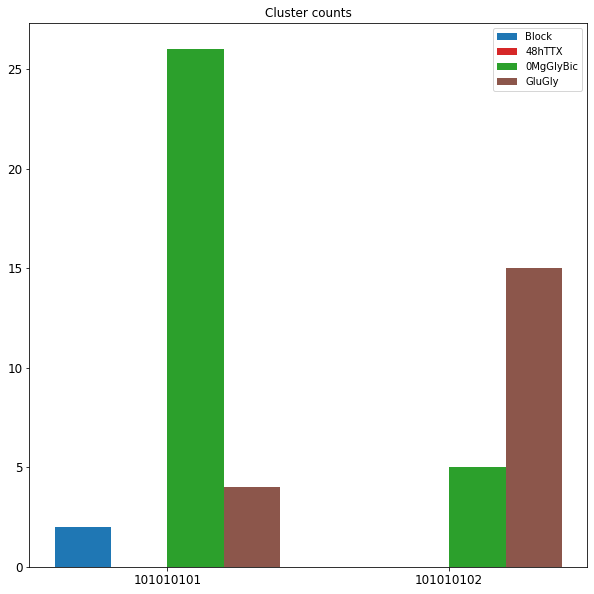

{101010101: {'Block': 2, '48hTTX': 0, '0MgGlyBic': 26, 'GluGly': 4},
 101010102: {'Block': 0, '48hTTX': 0, '0MgGlyBic': 5, 'GluGly': 15}}

In [84]:
plot_frequencies(nodes_to_compare)